#  Proyecto Amparo con LangChain y LangGraph
Este proyecto se desarrollará utilizando una **Arquitectura de agente** tipo **Superviro**.
En esta arquitectura usa un LLM para orquestar y delegar a agentes individuales

### Objetivos:
* Crear un grafo con una arquitectura multiagente tipo Supervisor
* Crear un **react_agent** supervisor que delegará los trabajos al resto de agentes
* Crear otros 5 agentes especializados en trabajos y tareas
    * Agente **Amparo** --> Agente principal
    * Agente **Buker** --> Agente especializado en BUK
    * Agente **Planner** --> Agente especializado en entrega de tareas
    * Agente **Reglamento** --> Agente especializado en consultas del reglamento interno
    * Agente **Search Web** --> Agente especializado en consultas web para temas más generales
### Alcance:

El desarrollo de este sistema multiagente se desarrollará en N fases.
En una 1era fase se espera tener creado los nodos (sin ejecuión) y el grafo para la visualización de la arquitectura.


### Codigo del proyecto

### Instalación de paquetes y librerias
* lanchain_openai
* langchain_core
* langgraph
* langchain_community

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community langchain_anthropic langchain_experimental

### Importación de librerias


In [1]:
from typing import TypedDict, Literal
from langgraph.graph import MessagesState, END, START, StateGraph
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from dotenv import find_dotenv, load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display

### Carga de variables de entorno
* Agrega las API Keys 

In [2]:
# Cargar variables de entorno
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

### Definimos una estructura para el estado


In [3]:
class State(TypedDict):
    graph_state: str
    messages: list

### Definimos los agentes o miembros:
Estos son los que estarán en este sistema multi-agente tipo supervisor
   * Agente **Amparo** --> Agente principal
   * Agente **Buker** --> Agente especializado en BUK
   * Agente **Planner** --> Agente especializado en entrega de tareas
   * Agente **Reglamento** --> Agente especializado en consultas del reglamento interno
   * Agente **Search Web** --> Agente especializado en consultas web para temas más generales

In [4]:
members = ["amparo", "buker", "planner", "reglamento", "search_web"]
options = members + ["FINISH"]

### System Prompt
Entregamos el prompt que usará el supervisor para dirigir el trabajo a los diferentes agente

In [5]:
# Prompt del sistema
system_prompt = (
    "Eres un supervisor de RRHH que trabaja para las empresas constructora del mar II e inmobiliaria costanera pacifico "
    f"y eres el encargado de gestionar las conversaciones y solicitudes entre los siguientes miembros: {members}. "
    "Ante la siguiente solicitud del usuario, responda con el miembro que debe actuar a continuación. "
    "Cada miembro realizará una tarea y responderá con sus resultados y el estado. Al finalizar, responda con FINISH."
)

### Creación del Router
Este se encargará de dirigir la flujo entre los agentes

In [6]:
class Router(TypedDict):
    next: Literal[options]

### Selección del modelo
En este caso se usará **gpt-3.5-turbo**

In [7]:
# Configurar modelo de lenguaje
llm = ChatOpenAI(model="gpt-3.5-turbo")

### Creamos el Agente Supervisor
 Este se encargará de orquestar el sistema

In [8]:
# Definir nodo supervisor
def supervisor_node(state: State) -> Command:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    if goto == "FINISH":
        goto = END  # ✅ Usa END en vez de un string "END"
    
    return Command(goto=goto, update={"next": goto})

### Continuamos con la creación preliminar del resto de agentes


In [9]:
# Definir los nodos restantes como Commands en vez de strings
def amparo(state: State) -> Command:
    return Command(goto="supervisor_node")

def buker(state: State) -> Command:
    return Command(goto="supervisor_node")

def planner(state: State) -> Command:
    return Command(goto="supervisor_node")

def reglamento(state: State) -> Command:
    return Command(goto="supervisor_node")

### Tools y agent Search Web

In [10]:
# Configurar herramientas de búsqueda
tavily_tool = TavilySearchResults(max_results=5)

In [11]:
# Crear agente de investigación
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)

# Nodo de búsqueda web
def research_node(state: State) -> Command:
    result = research_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="researcher")]},
        goto="supervisor_node",
    )

def search_web(state: State) -> Command:
    return Command(goto="supervisor_node")

### Construcción del Grafo

In [16]:
builder = StateGraph(State)

### Añadir Nodos

In [17]:
builder.add_node("supervisor_node", supervisor_node)
builder.add_node("amparo", amparo)
builder.add_node("buker", buker)
builder.add_node("planner", planner)
builder.add_node("reglamento", reglamento)
builder.add_node("search_web", search_web)

### Definiciónde Edges

In [18]:
# Definir conexiones entre nodos
builder.add_edge(START, "supervisor_node")
builder.add_edge("supervisor_node", "amparo")
builder.add_edge("amparo", "supervisor_node")
builder.add_edge("supervisor_node", "buker")
builder.add_edge("buker", "supervisor_node")
builder.add_edge("supervisor_node", "planner")
builder.add_edge("planner", "supervisor_node")
builder.add_edge("supervisor_node", "reglamento")
builder.add_edge("reglamento", "supervisor_node")
builder.add_edge("supervisor_node", "search_web")
builder.add_edge("search_web", "supervisor_node")
builder.add_edge("supervisor_node", END)  # ✅ Asegurar que END es un valor válido

### Compilación y visaulización del grafo

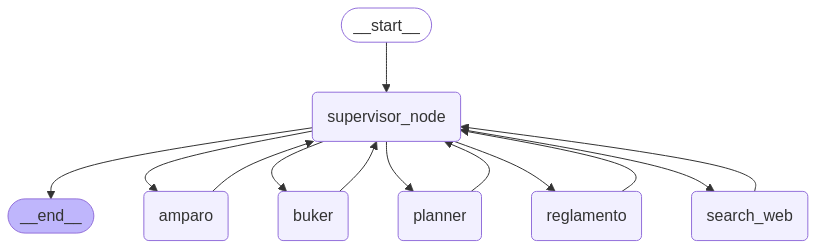

In [19]:
# Compilar y mostrar el gráfico de estados
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))